# Quantization Visualization

## Authors:
### **Fluid Numerics**
* **Garrett Byrd**             ([garrett@fluidnumerics.com](garrett@fluidnumerics.com))
* **Dr. Joseph Schoonover**    ([joe@fluidnumerics.com](joe@fluidnumerics.com))

In [274]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os.path

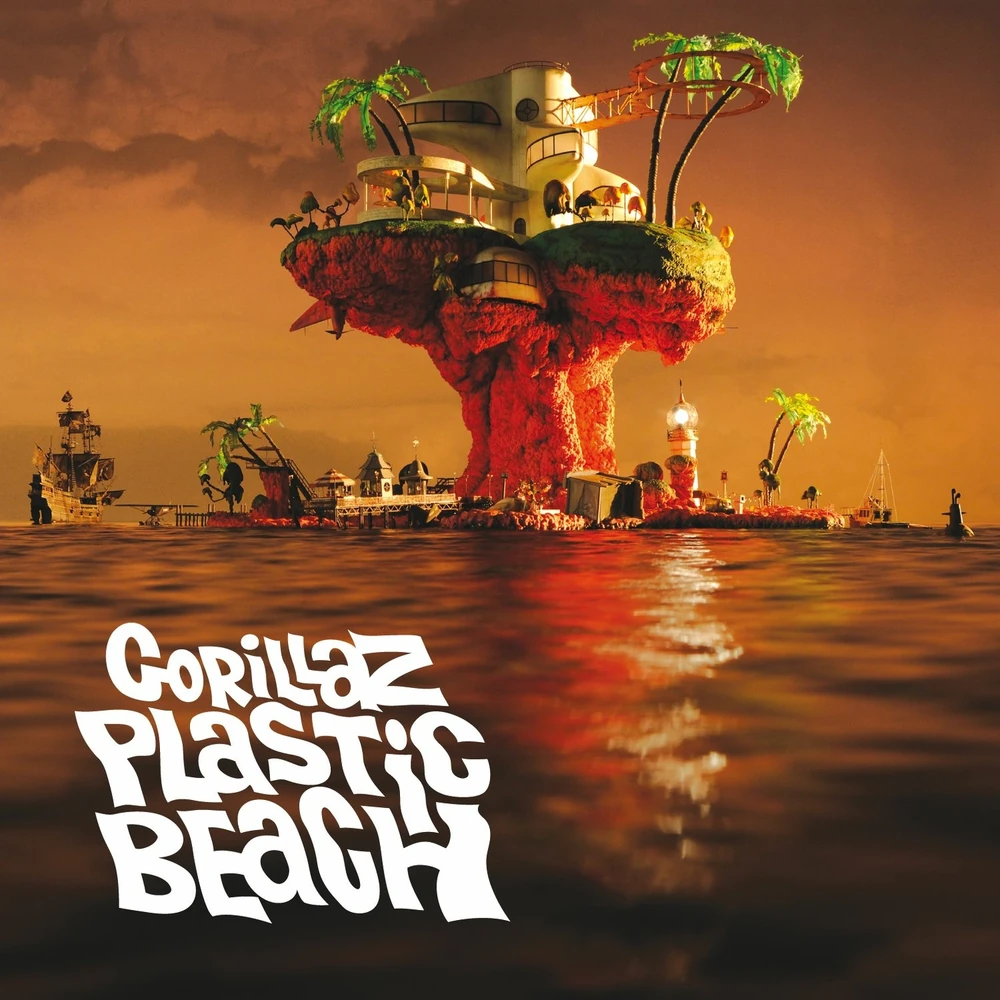

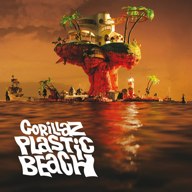

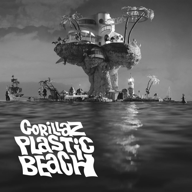

In [275]:
# Import original image
image_path = "plastic-beach.tif"
full_color_image = Image.open(image_path)

# Resize
input_shape = (192, 192)
color_image = Image.open(image_path).resize(input_shape)
# Grayscale
input = Image.open(image_path).convert("L").resize(input_shape)
# Rescale to [0.0,1.0]
image_array = np.asarray(input) / 255

# Save images
full_color_image.save("full_size_color.png", format="png")
color_image.save("color.png", format="png")
input.save("grayscale.png", format="png")

# Original image (1000x1000 rank-3 tensor)
display(full_color_image)
# Lower resolution (192x192 rank-3 tensor)
display(color_image)
# Grayscale (192x192 rank-2 tensor)
display(input)

In [276]:
# Round pixel values to nearest value of the form x / (2**n - 1)
def _posterize(value, bit):
    value = float(value)
    bit_range = [((i - 1) / (2**bit - 1)) for i in range(1, 2**bit + 1)]
    distances = [abs(value - element) for element in bit_range]
    y = bit_range[distances.index(min(distances))]
    return y


posterize = np.vectorize(_posterize)

In [277]:
# Generate posterized images
for i in range(8, 0, -1):
    # Skip if file exists
    if not os.path.isfile(f"posterized_{i}_bit.png"):
        quantized = posterize(image_array, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(quantized, cmap="gray", vmin=0, vmax=1)
        plt.title(f"posterized to {i}-bit")
        if i == 8:
            plt.title(f"posterized to {i}-bit (unchanged)")

        plt.savefig(f"posterized_{i}_bit.png", dpi=512, bbox_inches="tight")

# Generate gif of different bit depths per posterization
if not os.path.isfile("posterization.gif"):
    frames = [Image.open(f"posterized_{i}_bit.png") for i in range(8, 0, -1)]
    frame_one = frames[0]
    frame_one.save(
        "posterization.gif",
        format="gif",
        append_images=frames[1:],
        save_all=True,
        duration=1000,
        loop=0,
    )

In [278]:
# Generate concatenated image (visualization purposes only)
slices = [cv2.imread(f"posterized_{i}_bit.png") for i in range(8, 0, -1)]
row_1 = cv2.hconcat(slices[:4])
row_2 = cv2.hconcat(slices[4:])
final = cv2.vconcat([row_1, row_2])
cv2.imwrite("combined.png", final)

True

In [279]:
# Quantiziation algorithm per block
def _n_bit_quantize(value, n):
    value = float(value)
    bit_range = [(i / (2**n)) for i in range(2**n)]
    distances = [abs(value - element) for element in bit_range]
    y = bit_range[distances.index(min(distances))]
    index = distances.index(min(distances))
    return y, int(index)


n_bit_quantize = np.vectorize(_n_bit_quantize)

In [280]:
# closest_number finds an integer near n
# that divides m
def _closest_number(m, n):
    if m % n == 0:
        return int(m / n)
    else:
        for i in range(n + 1, 2 * n + 1):
            if m % i == 0:
                return int(m / i)
        for j in range(n, 0, -1):
            if m % j == 0:
                return int(m / j)


closest_number = np.vectorize(_closest_number)

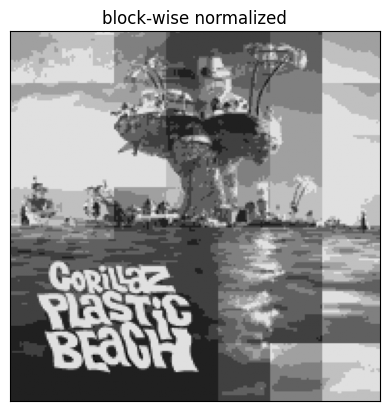

In [281]:
# Block-wise Quantization

# Init arrays
quantized_image = np.zeros(image_array.shape)
indexed_image = np.zeros(image_array.shape).astype(int)

# Example: 3-bit blockwise quantization
quantized_bit = 3

# Number of blocks in one row/column
divisor = 7
# Each block will have shape_quotients*shape_quotients elements
# (except for last block, if shape_quotients does not evenly divide image shape)
shape_quotients = np.floor(np.asarray(image_array.shape) / divisor).astype(int)

# Array to store scaling factors
normalization_factors = np.zeros([divisor, divisor])

# Used for calculating block shapes
imax = divisor
jmax = divisor

# Steps in Block-wise quantization procedure
# are analogous to steps provided in Fig. 1 of
# https://arxiv.org/abs/2110.02861

# Quantize
for i in range(imax):
    for j in range(jmax):
        # Chunk into blocks
        block_x_lower = i * shape_quotients[0]
        block_y_lower = j * shape_quotients[1]
        block_x_upper = (i + 1) * shape_quotients[0]
        block_y_upper = (j + 1) * shape_quotients[1]
        if i + 1 == imax:
            block_x_upper = image_array.shape[1]
        if j + 1 == imax:
            block_y_upper = image_array.shape[1]
        block = image_array[block_x_lower:block_x_upper, block_y_lower:block_y_upper]
        # Find block-wise absmax
        absmax = np.max(np.abs(block))
        # Normalize with absmax
        normalized_block = block / absmax
        # (save scaling factor)
        normalization_factors[i, j] = absmax
        # Find closest 8-bit value &
        # Find corresponding index
        bit_block, index_block = n_bit_quantize(normalized_block, quantized_bit)
        quantized_image[block_x_lower:block_x_upper, block_y_lower:block_y_upper] = (
            bit_block
        )
        indexed_image[block_x_lower:block_x_upper, block_y_lower:block_y_upper] = (
            index_block
        )

# Visualize
plt.xticks([])
plt.yticks([])
plt.imshow(quantized_image, cmap="gray", vmin=0, vmax=1)
plt.title("block-wise normalized")
plt.savefig(f"blockwise_normalized.png", dpi=512, bbox_inches="tight")
plt.show()

# Each block is normalized to [0.0, 1.0],
# so blocks with high range (both dark and light regions) will not scale very much
# but block with low range (just dark or just light regions) will scale more significantly.

In [282]:
# De-index for de-quantization
def _deindex(index, bit):
    return [(i / (2**bit)) for i in range(0, 2**bit)][index]


deindex = np.vectorize(_deindex)

In [283]:
# Init array
reconstructed_image = np.zeros(image_array.shape)

# Similarly to quantization, the steps in dequantization procedure are described in
# https://arxiv.org/abs/2110.02861

# Dequantize
for i in range(imax):
    for j in range(jmax):
        # Index
        block_x_lower = i * shape_quotients[0]
        block_y_lower = j * shape_quotients[1]
        block_x_upper = (i + 1) * shape_quotients[0]
        block_y_upper = (j + 1) * shape_quotients[1]
        if i + 1 == imax:
            block_x_upper = image_array.shape[1]
        if j + 1 == imax:
            block_y_upper = image_array.shape[1]
        index_block = indexed_image[
            block_x_lower:block_x_upper, block_y_lower:block_y_upper
        ]
        # Lookup values
        deindex_block = deindex(index_block, quantized_bit)
        # Denormalize by absmax
        denormalized_block = deindex_block * normalization_factors[i, j]
        reconstructed_image[
            block_x_lower:block_x_upper, block_y_lower:block_y_upper
        ] = denormalized_block

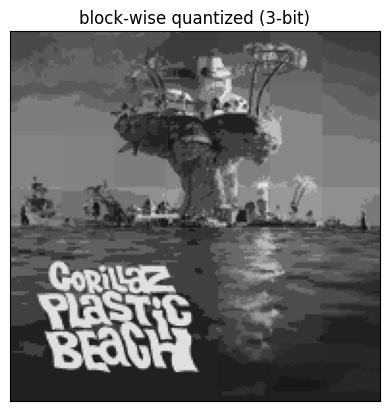

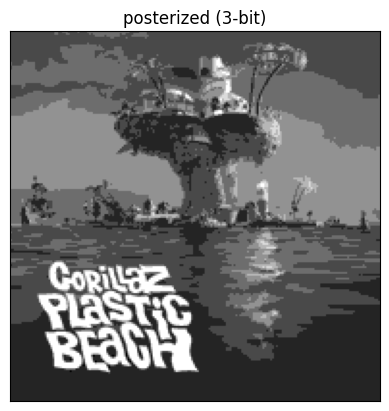

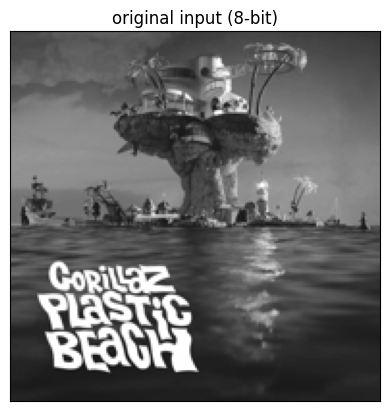

In [284]:
# Visualization
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_image, cmap="gray", vmin=0, vmax=1)
plt.title(f"block-wise quantized (3-bit)")
plt.savefig(
    f"blockwise_quantized_{quantized_bit}_bit.png", dpi=512, bbox_inches="tight"
)
plt.show()

plt.xticks([])
plt.yticks([])
plt.imshow(posterize(image_array, 3), cmap="gray", vmin=0, vmax=1)
plt.title(f"posterized (3-bit)")
plt.savefig(
    f"posterized_{quantized_bit}_bit_comparison.png", dpi=512, bbox_inches="tight"
)
plt.show()

plt.xticks([])
plt.yticks([])
plt.imshow(image_array, cmap="gray", vmin=0, vmax=1)
plt.title(f"original input (8-bit)")
plt.savefig(f"original_input.png", dpi=512, bbox_inches="tight")
plt.show()